## Load the data

In [1]:
# !pip install adjustText
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
from adjustText import adjust_text

pd.set_option('mode.chained_assignment', None)
%config InlineBackend.figure_format = 'retina'

In [2]:
colors = {
    'ARI':'#97233F',
    'ATL':'#A71930',
    'BAL':'#241773',
    'BUF':'#00338D',
    'CAR':'#0085CA',
    'CHI':'#C83803',
    'CIN':'#FB4F14',
    'CLE':'#311D00',
    'DAL':'#041E42',
    'DEN':'#FB4F14',
    'DET':'#0076B6',
    'GB' :'#203731',
    'HOU':'#03202F',
    'IND':'#002C5F',
    'JAX':'#006778',
    'JAC':'#006778',
    'KC' :'#E31837',
    'LAC':'#0080C6',
    'SD':'#0080C6',
    'LAR':'#866D4B',
    'LA':'#866D4B',
    'STL':'#866D4B',
    'MIA':'#008E97',
    'MIN':'#4F2683',
    'NE' :'#002244',
    'NO' :'#D3BC8D',
    'NYG':'#0B2265',
    'NYJ':'#125740',
    'OAK':'#A5ACAF',
    'PHI':'#004C54',
    'PIT':'#FFB612',
    'SEA':'#69BE28',
    'SF' :'#AA0000',
    'TB' :'#D50A0A',
    'TEN':'#0C2340',
    'WAS':'#773141'
}

kc_p = '#E31837'
kc_s = '#FFB81C'

In [3]:
df = pd.read_csv('pbp_2000_2019.csv', low_memory=False)

In [4]:
roster_df = pd.read_csv('roster.csv', low_memory=False)

In [5]:
#I always forget column names - and there's a lot of them - so I like to list them before I start analyzing
list(df)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

## Analysis

Let's start with a simple look at EPA per Carry and Yards per Carry

In [6]:
df = df.loc[(df['season_type']=='REG')]

In [7]:
#Get RB EPA, WPA, yards per carry
rbs_df = df.groupby(by=['rusher_player_id'])[['epa','yards_gained','wpa']].mean()
rbs_df['attempts'] = df.groupby(by='rusher_player_id')[['epa']].count()
rbs_df = rbs_df.loc[(rbs_df['attempts']>=1000)]
rbs_df.reset_index(inplace=True)


In [8]:
rbs_df.head(10)

,rusher_player_id,epa,yards_gained,wpa,attempts
0,00-0000745,-0.112576,4.827586,0.000098,1830
1,00-0001215,-0.172909,3.780044,-0.001883,1297
2,00-0004052,-0.197771,4.001372,-0.003467,1339
3,00-0004304,-0.149311,4.180451,-0.002667,1686
4,00-0004640,-0.178065,4.155533,-0.003064,1973
5,00-0005092,-0.260118,4.650582,0.000763,1071
6,00-0005883,-0.375073,3.366048,-0.004662,1339
7,00-0006305,-0.154302,4.449123,-0.002272,1788
8,00-0007661,-0.089276,4.564770,0.000933,1186
9,00-0008241,-0.125641,4.015385,-0.000808,2552


In [9]:
list(roster_df)

['team.season',
 'teamPlayers.displayName',
 'teamPlayers.firstName',
 'teamPlayers.middleName',
 'teamPlayers.lastName',
 'teamPlayers.suffix',
 'teamPlayers.status',
 'teamPlayers.positionGroup',
 'teamPlayers.position',
 'teamPlayers.nflId',
 'teamPlayers.esbId',
 'teamPlayers.gsisId',
 'teamPlayers.birthDate',
 'teamPlayers.homeTown',
 'teamPlayers.collegeId',
 'teamPlayers.collegeName',
 'teamPlayers.jerseyNumber',
 'teamPlayers.height',
 'teamPlayers.weight',
 'team.teamId',
 'team.abbr',
 'team.cityState',
 'team.fullName',
 'team.nick',
 'team.conferenceAbbr',
 'team.divisionAbbr',
 'teamPlayers.headshot_url',
 'teamPlayers.profile_url']

Now, this is just all *rushers*, it's not all running backs. We likely have some QBs in this data. To get just RBs, we need roster data. Since we have multiple years in our roster data, we're going to do something a bit unorthodox - just look at player ID and position. This works because we know a players position hasn't changed

In [10]:
#Get the most common value (mode) for a players position , and a players team
positions = roster_df.groupby(['teamPlayers.gsisId','teamPlayers.displayName'])[['teamPlayers.positionGroup']].agg(lambda x:x.value_counts().index[0])
positions['team'] = roster_df.groupby(['teamPlayers.gsisId','teamPlayers.displayName'])[['team.abbr']].agg(lambda x:x.value_counts().index[0])
positions.reset_index(inplace=True)

In [11]:
positions.head(10)

,teamPlayers.gsisId,teamPlayers.displayName,teamPlayers.positionGroup,team
0,00-0000003,Abdul-Karim al-Jabbar,RB,CLE
1,00-0000007,Rabih Abdullah,RB,TB
2,00-0000008,Rahim Abdullah,LB,CLE
3,00-0000017,Donnie Abraham,DB,TB
4,00-0000025,Kevin Abrams,DB,DET
5,00-0000032,Tom Ackerman,OL,NO
6,00-0000045,Flozell Adams,OL,DAL
7,00-0000065,Sam Adams,DL,BUF
8,00-0000072,Vashone Adams,DB,DAL
9,00-0000097,Ray Agnew,DL,STL


In [12]:
#Get only RBs
rbs_only = positions.loc[(positions['teamPlayers.positionGroup']=='RB')]

In [13]:
#Merge with aggregated RB data, using an inner join to only get players with both RB position and the previous constraints
rbs = pd.merge(rbs_only, rbs_df, how='inner', left_on='teamPlayers.gsisId', right_on='rusher_player_id')

In [14]:
#see top performing RBs by this metric
rbs.sort_values(by='epa', ascending=False, inplace=True)
rbs.reset_index(inplace=True)
rbs.head(10)

,index,teamPlayers.gsisId,teamPlayers.displayName,teamPlayers.positionGroup,team,rusher_player_id,epa,yards_gained,wpa,attempts
0,51,00-0026213,Jamaal Charles,RB,KC,00-0026213,0.039941,5.375267,0.001513,1403
1,67,00-0033045,Ezekiel Elliott,RB,DAL,00-0033045,0.027399,4.623610,0.000950,1165
2,57,00-0027966,Mark Ingram,RB,NO,00-0027966,0.006243,4.601046,0.000295,1522
3,38,00-0024242,DeAngelo Williams,RB,CAR,00-0024242,-0.005592,4.665704,0.000856,1725
4,40,00-0024275,Maurice Jones-Drew,RB,JAX,00-0024275,-0.015061,4.414595,0.000195,1848
5,39,00-0024245,Joseph Addai,RB,IND,00-0024245,-0.019318,4.056518,0.002236,1095
6,58,00-0028009,DeMarco Murray,RB,DAL,00-0028009,-0.019817,4.472569,-0.000049,1602
7,34,00-0023544,Marion Barber,RB,DAL,00-0023544,-0.021964,4.134948,-0.000104,1150
8,22,00-0021216,Brian Westbrook,RB,PHI,00-0021216,-0.028177,4.574007,-0.000219,1369
9,28,00-0022821,Michael Turner,RB,ATL,00-0022821,-0.028733,4.477120,-0.000052,1637


In [15]:
print(len(rbs))

68


There's Jamaal! Time to visualize

Text(19.653000000000006, 0.5, 'Expected Points Added (EPA) per Carry')

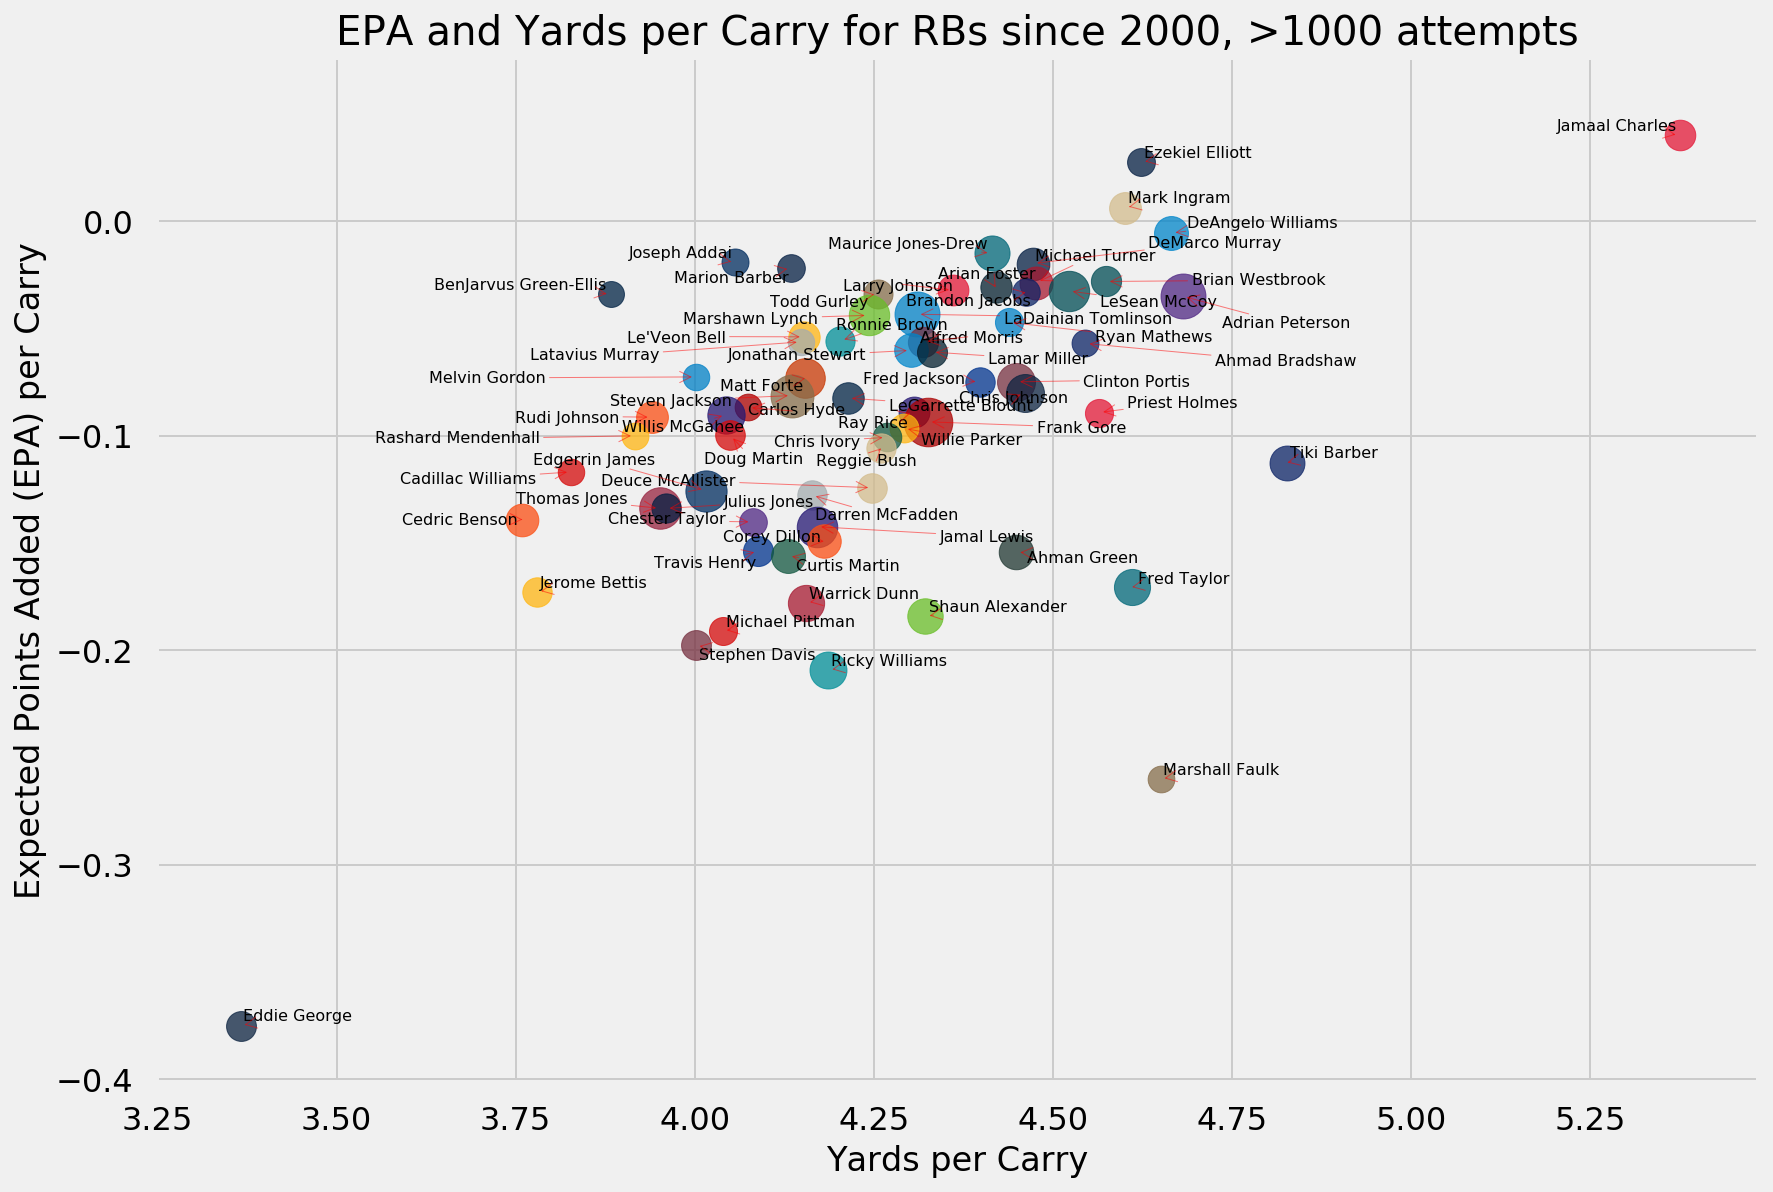

In [16]:
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

#Define a helper function for plotting

def colored_scatterplot(df, x_name, y_name, player_name, team_name, transparency, size):
    
    x = list(df[x_name])
    y = list(df[y_name])
    names = list(df[player_name])
    
    for index,row in df.iterrows():
        plt.scatter(row[x_name], row[y_name], c=colors[row[team_name]], alpha=transparency, s=row[size]/6)
        
#         plt.annotate(row[player_name], (row[x_name],row[y_name]),
#                     textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center',fontsize = 8, alpha=0.9)
    
    texts = [plt.text(x[i], y[i], names[i], fontsize=8) for i in range(len(x))]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))
    plt.show
    return x,y,names

x,y,names = colored_scatterplot(rbs, 'yards_gained', 'epa', 'teamPlayers.displayName', 'team', 0.75, 'attempts')

plt.title('EPA and Yards per Carry for RBs since 2000, >1000 attempts')
plt.xlabel('Yards per Carry')
plt.ylabel('Expected Points Added (EPA) per Carry')

In [17]:
len(names)

68

Add passing game

In [18]:
list(df)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [19]:
rbs_df = df.groupby(by=['receiver_player_id'])[['epa','yards_gained','wpa']].mean()
rbs_df['targets'] = df.groupby(by='receiver_player_id')[['epa']].count()
rbs_df = rbs_df.loc[(rbs_df['targets']>=200)]
rbs_df.reset_index(inplace=True)
rbs_df

,receiver_player_id,epa,yards_gained,wpa,targets
0,00-0000166,0.000295,7.031008,0.005743,241
1,00-0000251,0.041868,5.533333,0.002183,201
2,00-0000339,-0.166342,6.431677,0.001215,311
3,00-0000745,0.233668,7.539924,0.007409,473
4,00-0001477,0.148252,8.769959,0.009009,702
...,...,...,...,...,...
437,00-0033908,0.497056,9.205674,0.013490,281
438,00-0033921,0.506764,9.868613,0.014256,273
439,00-0033932,0.417828,9.479167,0.014037,288
440,00-0034348,0.369854,8.687500,0.014187,207


In [20]:
#Merge with aggregated RB data, using an inner join to only get players with both RB position and the previous constraints
rbs_passing = pd.merge(rbs_only, rbs_df, how='inner', left_on='teamPlayers.gsisId', right_on='receiver_player_id')

In [21]:
rbs_passing.columns= ['teamPlayers.gsisId','name','position','team_wr','receiver_id','epa_tgt','yds_tgt','wpa_tgt','tgts']

In [22]:
rbs_total = pd.merge(rbs, rbs_passing, how='inner', left_on='teamPlayers.gsisId', right_on='teamPlayers.gsisId')

In [23]:
rbs_total.sort_values(by='epa_tgt',ascending=False)

,index,teamPlayers.gsisId,teamPlayers.displayName,teamPlayers.positionGroup,team,rusher_player_id,epa,yards_gained,wpa,attempts,name,position,team_wr,receiver_id,epa_tgt,yds_tgt,wpa_tgt,tgts
7,22,00-0021216,Brian Westbrook,RB,PHI,00-0021216,-0.028177,4.574007,-0.000219,1369,Brian Westbrook,RB,PHI,00-0021216,0.340632,8.090349,0.010326,484
5,39,00-0024245,Joseph Addai,RB,IND,00-0024245,-0.019318,4.056518,0.002236,1095,Joseph Addai,RB,IND,00-0024245,0.281127,6.672811,0.008856,217
33,0,00-0000745,Tiki Barber,RB,NYG,00-0000745,-0.112576,4.827586,0.000098,1830,Tiki Barber,RB,NYG,00-0000745,0.233668,7.539924,0.007409,473
39,16,00-0019693,Jamal Lewis,RB,BAL,00-0019693,-0.142481,4.170991,-0.001812,2467,Jamal Lewis,RB,BAL,00-0019693,0.231563,7.546185,0.007356,243
4,40,00-0024275,Maurice Jones-Drew,RB,JAX,00-0024275,-0.015061,4.414595,0.000195,1848,Maurice Jones-Drew,RB,JAX,00-0024275,0.231240,7.016667,0.004935,420
15,62,00-0030496,Le'Veon Bell,RB,PIT,00-0030496,-0.053975,4.152542,-0.000059,1474,Le'Veon Bell,RB,PIT,00-0030496,0.208009,6.584034,0.005042,474
23,21,00-0021179,Clinton Portis,RB,WAS,00-0021179,-0.074957,4.448678,-0.000372,2158,Clinton Portis,RB,WAS,00-0021179,0.183976,6.894198,0.003391,282
32,37,00-0024217,Reggie Bush,RB,NO,00-0024217,-0.105924,4.260465,-0.002529,1288,Reggie Bush,RB,NO,00-0024217,0.182917,6.154110,0.005842,583
18,43,00-0025637,Ahmad Bradshaw,RB,NYG,00-0025637,-0.057069,4.545622,-0.001222,1084,Ahmad Bradshaw,RB,NYG,00-0025637,0.157038,6.246862,0.002761,239
28,8,00-0007661,Priest Holmes,RB,KC,00-0007661,-0.089276,4.564770,0.000933,1186,Priest Holmes,RB,KC,00-0007661,0.154315,8.144201,0.008302,270


Text(9.528000000000006, 0.5, 'Expected Points Added (EPA) per Carry')

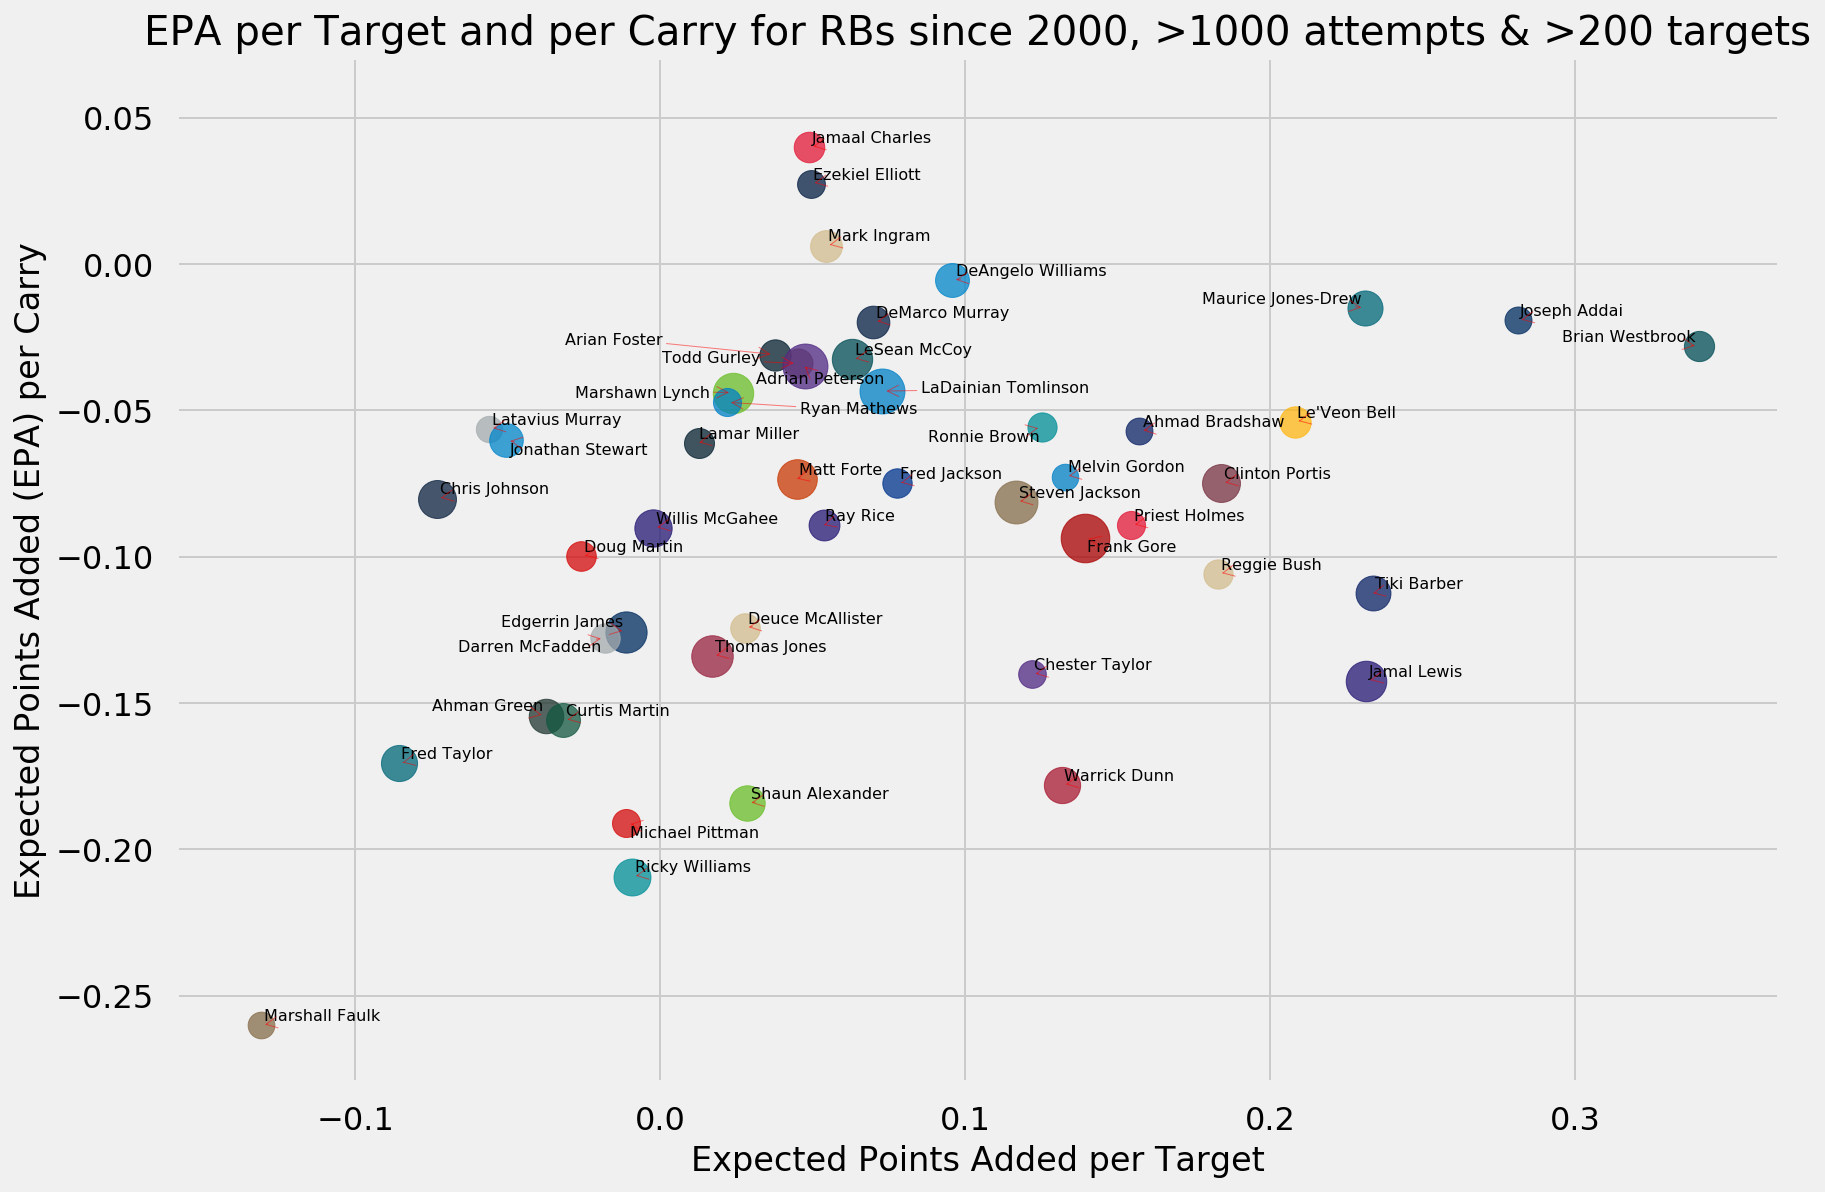

In [24]:
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

#Define a helper function for plotting

def colored_scatterplot(df, x_name, y_name, player_name, team_name, transparency, size):
    
    x = list(df[x_name])
    y = list(df[y_name])
    names = list(df[player_name])
    
    for index,row in df.iterrows():
        plt.scatter(row[x_name], row[y_name], c=colors[row[team_name]], alpha=transparency, s=row[size]/6)
        
#         plt.annotate(row[player_name], (row[x_name],row[y_name]),
#                     textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center',fontsize = 8, alpha=0.9)
    
    texts = [plt.text(x[i], y[i], names[i], fontsize=8) for i in range(len(x))]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))
    plt.show
    return x,y,names

x,y,names = colored_scatterplot(rbs_total, 'epa_tgt', 'epa', 'teamPlayers.displayName', 'team', 0.75, 'attempts')

plt.title('EPA per Target and per Carry for RBs since 2000, >1000 attempts & >200 targets')
plt.xlabel('Expected Points Added per Target')
plt.ylabel('Expected Points Added (EPA) per Carry')

Cumulative EPA

Text(0.5, 0.98, 'Most Prolific RBs Since 2000\n')

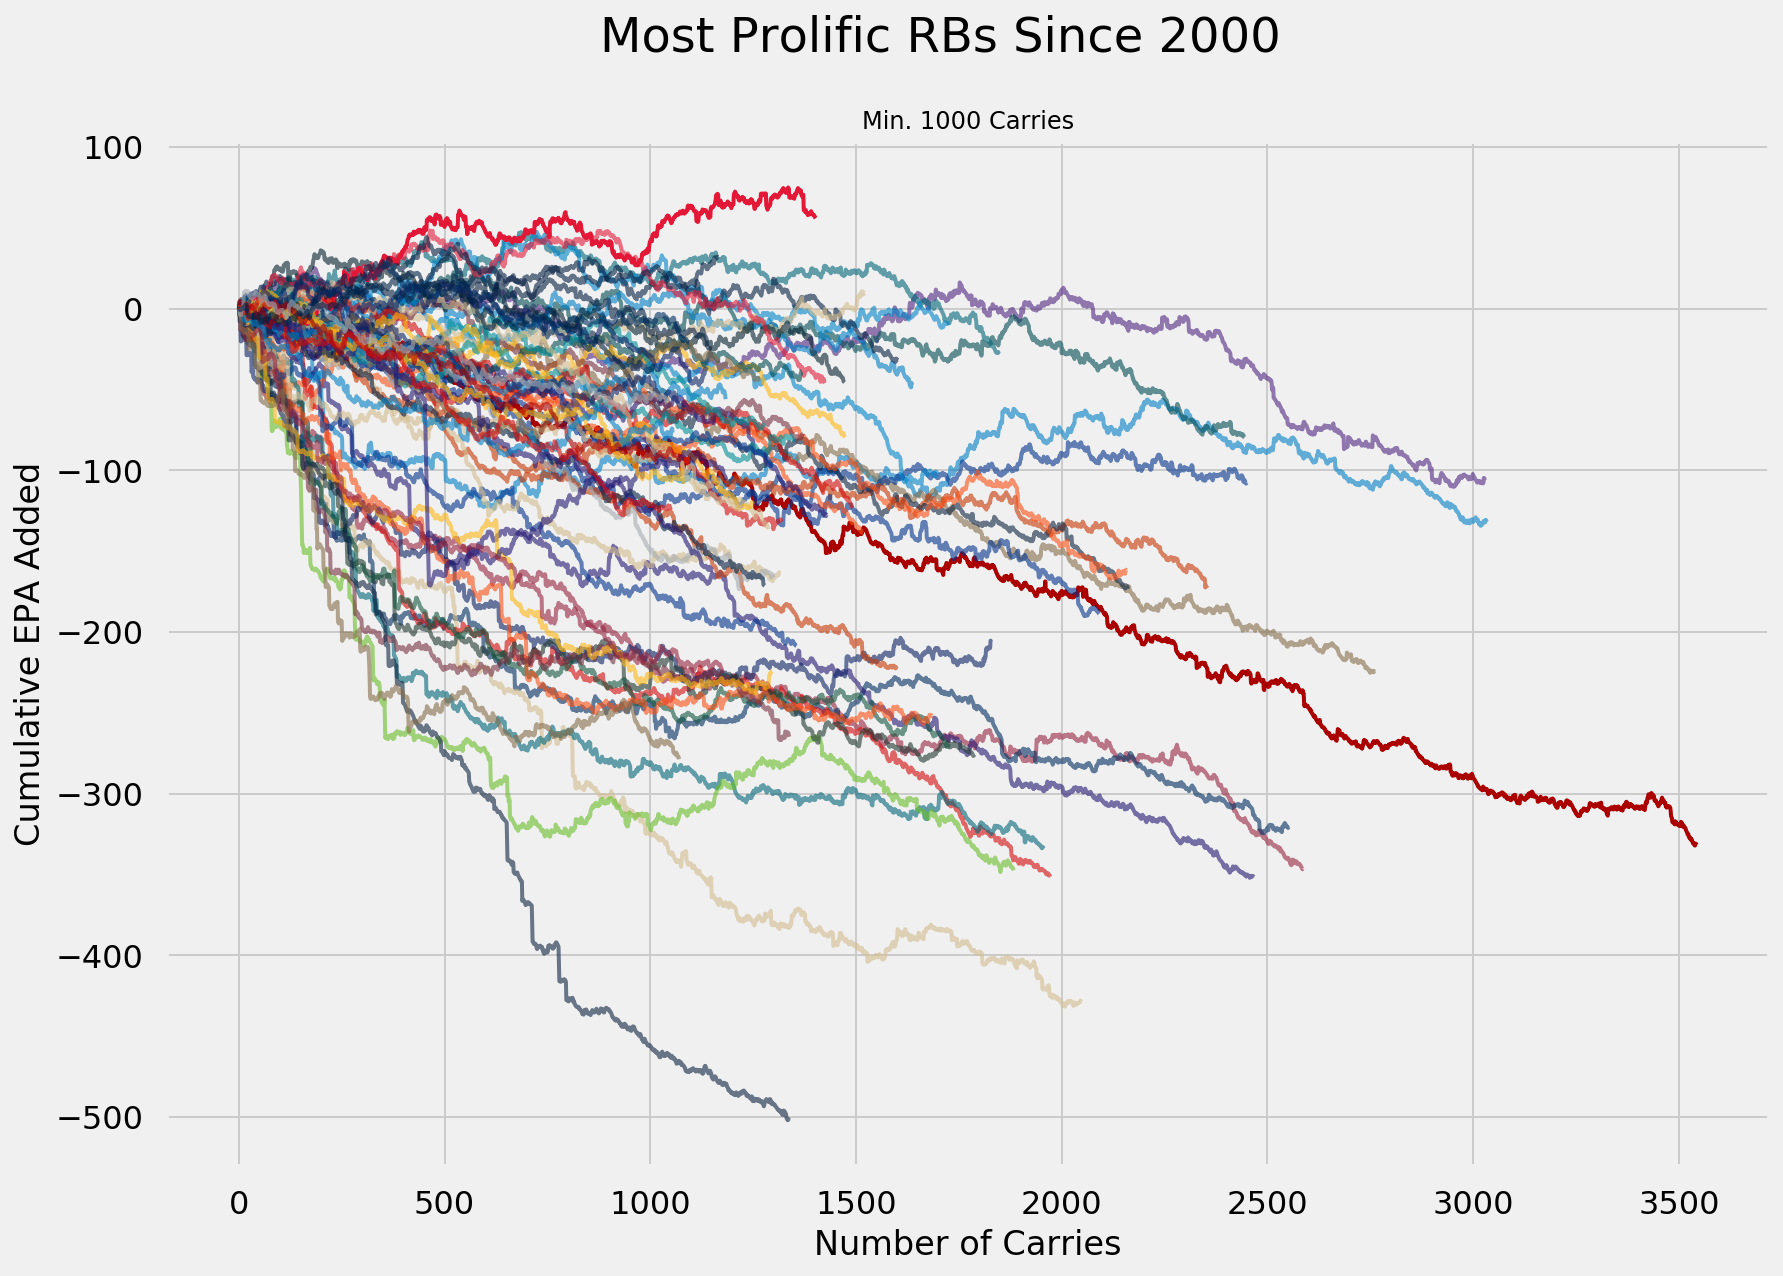

In [26]:
# # sns.set_palette("tab20c",plt.cm.tab20c.N )
# plt.style.use('seaborn-talk')
# plt.style.use('seaborn-poster')

from cycler import cycler
c = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=c)

rbs.sort_values(by='attempts',ascending=False, inplace=True)
players = list(rbs['teamPlayers.gsisId'])

rb_sum = df.loc[(df['rusher_player_id'].isin(players)) & (df['epa'].notnull())]
for rb in players:
    if rb=='00-0026213' or rb=='00-0023500':
        temp_df = rb_sum.loc[(rb_sum['rusher_player_id']==rb)]
        temp_df['rolling_epa'] = temp_df.epa.cumsum()
        temp_df.reset_index(inplace=True)
        plt.plot(temp_df['rolling_epa'],lw=2,
                 label=temp_df['rusher_player_name'].iloc[0],
                 c=colors[temp_df['posteam'].iloc[0]])
    else:
        temp_df = rb_sum.loc[(rb_sum['rusher_player_id']==rb)]
        temp_df['rolling_epa'] = temp_df.epa.cumsum()
        temp_df.reset_index(inplace=True)
        plt.plot(temp_df['rolling_epa'],lw=2,
                 label=temp_df['rusher_player_name'].iloc[0],
                 c=colors[temp_df['posteam'].iloc[0]],
                alpha=0.6) 
        
    
# plt.legend(loc='best')
plt.xlabel('Number of Carries')
plt.ylabel('Cumulative EPA Added')
plt.title('Min. 1000 Carries',fontsize=12)
plt.suptitle('Most Prolific RBs Since 2000\n',fontsize=24)
# txt = "Data: nflscrapR | Chart: Ethan Douglas @chiefsanalytics"
# plt.figtext(0.1, -0.1, txt, wrap=True, horizontalalignment='left', fontsize=12)
# plt.xlim(0,1400)